In [1]:
import numpy as np
import pandas as pd
from biom import (load_table,
                  Table)
from qiime2 import (Artifact,
                    Metadata, Visualization)
from skbio import OrdinationResults, DistanceMatrix
from skbio.stats.distance import permanova
from qiime2.plugins.diversity.actions import beta, pcoa
from qiime2.plugins.gemelli.actions import rpca
from tqdm.notebook import tqdm
from scipy.spatial import ConvexHull

import colorsys
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex
plt.style.use('seaborn') 

%matplotlib inline

In [2]:
# import raw data
mf_df = pd.read_csv('../data/tumor_vs_nat/t_vs_nat_scaled_metadata_TCGA.csv', index_col=0)
mf_df = mf_df[mf_df.experimental_strategy == 'WGS']
tbl_df = pd.read_csv('../data/tumor_vs_nat/t_vs_nat_scaled_rel_abundances_TCGA.csv', index_col=0)
mf_df = mf_df.reindex(tbl_df.index)

mf_df.head(5)


,sample_name,run_prefix,experimental_strategy,cgc_base_name,filename,analyte_amount,analyte_A260A280Ratio,aliquot_concentration,cgc_id,cgc_filename,...,tissue_source_site_label,country_of_sample_procurement,portion_is_ffpe,pathologic_t_label,pathologic_n_label,histological_diagnosis_label,pathologic_stage_label,PlateCenter,PlateCenterFlag,disease_and_sample_type
13722.58cfa82de4b0c9d6adf6a4c2,58cfa82de4b0c9d6adf6a4c2,12dd02ea14d0a87df23ce3bef406fe27.filtered.,WGS,12dd02ea14d0a87df23ce3bef406fe27,12dd02ea14d0a87df23ce3bef406fe27.bam,32.75,NaN,0.08,58cfa82de4b0c9d6adf6a4c2,12dd02ea14d0a87df23ce3bef406fe27.bam,...,Duke,United States,NO,T2,N0,Infiltrating Ductal Carcinoma,Stage IIA,A21Q-09,True,Breast Invasive Carcinoma PT
13722.58cfa82de4b0c9d6adf6a502,58cfa82de4b0c9d6adf6a502,3d9f475186150ea055fddf25af7bb7e3.filtered.,WGS,3d9f475186150ea055fddf25af7bb7e3,3d9f475186150ea055fddf25af7bb7e3.bam,64.35,1.70,0.08,58cfa82de4b0c9d6adf6a502,3d9f475186150ea055fddf25af7bb7e3.bam,...,University of North Carolina,United States,NO,Not available,Not available,Endometrioid endometrial adenocarcinoma,Not available,A13L-09,False,Uterine Corpus Endometrial Carcinoma PT
13722.58cfa82de4b0c9d6adf6a4ce,58cfa82de4b0c9d6adf6a4ce,2258e57e8e0af9db6969a1da86177ca7.filtered.,WGS,2258e57e8e0af9db6969a1da86177ca7,2258e57e8e0af9db6969a1da86177ca7.bam,62.02,2.08,0.08,58cfa82de4b0c9d6adf6a4ce,2258e57e8e0af9db6969a1da86177ca7.bam,...,MSKCC,None,NO,T3,N2,Infiltrating Ductal Carcinoma,Stage IIIA,A19H-09,True,Breast Invasive Carcinoma PT
13722.58cfa82de4b0c9d6adf6a48a,58cfa82de4b0c9d6adf6a48a,142ba22e796cab1075278cd533a287c8.filtered.,WGS,142ba22e796cab1075278cd533a287c8,142ba22e796cab1075278cd533a287c8.bam,93.54,2.18,0.07,58cfa82de4b0c9d6adf6a48a,142ba22e796cab1075278cd533a287c8.bam,...,MSKCC,None,NO,Not available,Not available,Serous endometrial adenocarcinoma,Not available,A066-09,True,Uterine Corpus Endometrial Carcinoma PT
13722.58cfa82de4b0c9d6adf6a4d4,58cfa82de4b0c9d6adf6a4d4,406aecbc23505359850e57fbf05d5b67.filtered.,WGS,406aecbc23505359850e57fbf05d5b67,406aecbc23505359850e57fbf05d5b67.bam,85.32,1.85,0.08,58cfa82de4b0c9d6adf6a4d4,406aecbc23505359850e57fbf05d5b67.bam,...,MSKCC,None,NO,Not available,Not available,Serous endometrial adenocarcinoma,Not available,A066-09,True,Uterine Corpus Endometrial Carcinoma PT


In [20]:
# import data in Q2
bt = Table(tbl_df.values.T, tbl_df.columns, tbl_df.index)
table = Artifact.import_data('FeatureTable[Frequency]', bt)

# beta div calculations
bc_dist = beta(table, 'braycurtis').distance_matrix
jc_dist = beta(table, 'jaccard').distance_matrix
bc_pcoa = pcoa(bc_dist).pcoa
jc_pcoa = pcoa(jc_dist).pcoa
atch_biplot, atch_dist = rpca(table)

# save dists
bc_dist.save('../results/beta-div/bc-dist.qza')
jc_dist.save('../results/beta-div/jc-dist.qza')
bc_pcoa.save('../results/beta-div/bc-pcoa.qza')
jc_pcoa.save('../results/beta-div/jc-pcoa.qza')
atch_biplot.save('../results/beta-div/aitch-biplot.qza')
atch_dist.save('../results/beta-div/aitch-dist.qza')


/home/cmartino/.conda/envs/qiime2-2019.7/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1575: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/cmartino/.conda/envs/qiime2-2019.7/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -4.159800441090162 and the largest is 372.571715657325.
  RuntimeWarning
/home/cmartino/.conda/envs/qiime2-2019.7/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude wit

In [3]:
# save dists
bc_dist = Artifact.load('../results/beta-div/bc-dist.qza')
jc_dist = Artifact.load('../results/beta-div/jc-dist.qza')
bc_pcoa = Artifact.load('../results/beta-div/bc-pcoa.qza')
jc_pcoa = Artifact.load('../results/beta-div/jc-pcoa.qza')
atch_biplot = Artifact.load('../results/beta-div/aitch-biplot.qza')
atch_dist = Artifact.load('../results/beta-div/aitch-dist.qza')


In [4]:
# export distances
bc_dist_dm = bc_dist.view(DistanceMatrix)
jc_dist_dm = jc_dist.view(DistanceMatrix)
atch_dist_dm = atch_dist.view(DistanceMatrix)


In [5]:
# store results
permanova_results = {}
for dt_tmp, mf_tmp in tqdm(mf_df.groupby('disease_type')):
    if len(set(mf_tmp.sample_type)) != 2:
        continue
    # ensure matched / subset
    shared_ = set(mf_tmp.index) & set(bc_dist_dm.ids) & set(jc_dist_dm.ids) & set(atch_dist_dm.ids)
    bc_dist_dm_tmp = bc_dist_dm.copy().filter(shared_)
    jc_dist_dm_tmp = jc_dist_dm.copy().filter(shared_)
    atch_dist_dm_tmp = atch_dist_dm.copy().filter(shared_)
    # permanova within type across sample_type
    permanova_results[(dt_tmp, 'Bray-Curtis')] = permanova(bc_dist_dm_tmp,
                                                           mf_tmp['sample_type'])
    permanova_results[(dt_tmp, 'Aitchison')] = permanova(atch_dist_dm_tmp,
                                                         mf_tmp['sample_type'])


  0%|          | 0/32 [00:00<?, ?it/s]

In [6]:
# generate PERMANOVA results
permanova_results_df = pd.DataFrame(permanova_results).T
permanova_results_df.index.names = ['disease-type', 'metric']
permanova_results_df['q-value'] = permanova_results_df['p-value'] * len(set([x[0] for x in permanova_results_df.index]))
permanova_results_df.loc[permanova_results_df['q-value'] > 1, 'q-value'] = 1
permanova_results_df = permanova_results_df.loc[(slice(None), ['Bray-Curtis', 'Aitchison']), :]
permanova_results_df.to_csv('../results/beta-div/permaniva-res-sample-type.csv')
permanova_results_df.to_csv('../results/tables/beta-div/permaniva-res-sample-type.csv')
permanova_results_df.head(10)


method name  \
disease-type                                       metric                    
Bladder Urothelial Carcinoma                       Bray-Curtis   PERMANOVA   
                                                   Aitchison     PERMANOVA   
Breast Invasive Carcinoma                          Bray-Curtis   PERMANOVA   
                                                   Aitchison     PERMANOVA   
Cervical Squamous Cell Carcinoma and Endocervic... Bray-Curtis   PERMANOVA   
                                                   Aitchison     PERMANOVA   
Cholangiocarcinoma                                 Bray-Curtis   PERMANOVA   
                                                   Aitchison     PERMANOVA   
Colon Adenocarcinoma                               Bray-Curtis   PERMANOVA   
                                                   Aitchison     PERMANOVA   

                                                               test statistic name  \
disease-type                                       metric                            
Bladder Urothelial Carcinoma                       Bray-Curtis            pseudo-F   
                                                   Aitchison              pseudo-F   
Breast Invasive Carcinoma                          Bray-Curtis            pseudo-F   
                                                   Aitchison              pseudo-F   
Cervical Squamous Cell Carcinoma and Endocervic... Bray-Curtis            pseudo-F   
                                                   Aitchison              pseudo-F   
Cholangiocarcinoma                                 Bray-Curtis            pseudo-F   
                                                   Aitchison              pseudo-F   
Colon Adenocarcinoma                               Bray-Curtis            pseudo-F   
                                                   Aitchison              pseudo-F   

                                                               sample size  \
disease-type                                       metric                    
Bladder Urothelial Carcinoma                       Bray-Curtis         580   
                                                   Aitchison           580   
Breast Invasive Carcinoma                          Bray-Curtis        1251   
                                                   Aitchison          1251   
Cervical Squamous Cell Carcinoma and Endocervic... Bray-Curtis         364   
                                                   Aitchison           364   
Cholangiocarcinoma                                 Bray-Curtis          41   
                                                   Aitchison            41   
Colon Adenocarcinoma                               Bray-Curtis         465   
                                                   Aitchison           465   

                                                               number of groups  \
disease-type                                       metric                         
Bladder Urothelial Carcinoma                       Bray-Curtis                2   
                                                   Aitchison                  2   
Breast Invasive Carcinoma                          Bray-Curtis                2   
                                                   Aitchison                  2   
Cervical Squamous Cell Carcinoma and Endocervic... Bray-Curtis                2   
                                                   Aitchison                  2   
Cholangiocarcinoma                                 Bray-Curtis                2   
                                                   Aitchison                  2   
Colon Adenocarcinoma                               Bray-Curtis                2   
                                                   Aitchison                  2   

                                                               test statistic  \
disease-type                                       metric                     

In [355]:
# keep matched to WIS
keep_subset = ['Breast Invasive Carcinoma',
                 'Colon Adenocarcinoma',
                 'Lung Adenocarcinoma',
                 'Lung Squamous Cell Carcinoma',
                 'Ovarian Serous Cystadenocarcinoma',
                 'Rectum Adenocarcinoma']
# matched
mf_df_matched_groups = {k:{k2:df2
                           for k2, df2 in df.groupby(['tcga_case_id', 'data_submitting_center_label'])
                           if len(set(df2['sample_type'])) == 2}
                        for k, df in mf_df[mf_df.disease_type.isin(keep_subset)].groupby(['disease_type'])}

# store results
between_dist_results = {}
atch_dist_dm_df = pd.DataFrame(atch_dist_dm.data, atch_dist_dm.ids, atch_dist_dm.ids)
bc_dist_dm_df = pd.DataFrame(bc_dist_dm.data, bc_dist_dm.ids, bc_dist_dm.ids)
jc_dist_dm_df = pd.DataFrame(jc_dist_dm.data, jc_dist_dm.ids, jc_dist_dm.ids)
for metric_, dist_tmp in zip(['Aitchison', 'Bray-Curtis', 'Jaccard'],
                             [atch_dist_dm_df, bc_dist_dm_df, jc_dist_dm_df]):
    for ctype, sdict in tqdm(mf_df_matched_groups.items()):
        # get between all subjects in cancer type
        mf_tmp_within_dis = pd.concat(sdict.values())
        all_subjects_in_distype = list(mf_tmp_within_dis.index)
        # get all subjects outside this cancer type 
        all_subject_outside_distype = list(pd.concat([v1 for v in mf_df_matched_groups.values()
                                                      for v1 in v.values()]).index)
        all_subject_outside_distype = list(set(all_subject_outside_distype) - set(all_subjects_in_distype))
        # get dis type vs. other dis type
        bc_dist_dm_df_tmp = dist_tmp.loc[all_subject_outside_distype,
                                         all_subjects_in_distype].stack().reset_index()
        bc_dist_dm_df_tmp.columns = ['s1', 's2', 'distance']
        between_dist_results[(metric_, ctype, 'Between Cancer Type & All Other Types')] = bc_dist_dm_df_tmp
        # get all subject between NAT v. Tumor within dis type
        within_between_stype = []
        for s_, pair_df in sdict.items():
            bc_dist_dm_df_tmp = dist_tmp.loc[pair_df.index[[1]],
                                             pair_df.index[[0]]].stack().reset_index()
            bc_dist_dm_df_tmp.columns = ['s1', 's2', 'distance']
            within_between_stype.append(bc_dist_dm_df_tmp)
        between_dist_results[(metric_, ctype, 'Within Cancer Type Tumor vs. NAT')] = pd.concat(within_between_stype)
    

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [356]:
between_dist_results_df = pd.concat(between_dist_results)
between_dist_results_df.index.names = ['metric', 'disease-type', 'compare', 'dropme']
between_dist_results_df = between_dist_results_df.reset_index().drop('dropme', axis=1)
between_dist_results_df.head(4)


,metric,disease-type,compare,s1,s2,distance
0,Aitchison,Breast Invasive Carcinoma,Between Cancer Type & All Other Types,13722.58cfa830e4b0c9d6adf6baba,13722.58cfa82de4b0c9d6adf6a4b8,0.282111
1,Aitchison,Breast Invasive Carcinoma,Between Cancer Type & All Other Types,13722.58cfa830e4b0c9d6adf6baba,13722.58cfa82fe4b0c9d6adf6b8e0,0.107342
2,Aitchison,Breast Invasive Carcinoma,Between Cancer Type & All Other Types,13722.58cfa830e4b0c9d6adf6baba,13722.58cfa83ce4b0c9d6adf72ef8,0.223776
3,Aitchison,Breast Invasive Carcinoma,Between Cancer Type & All Other Types,13722.58cfa830e4b0c9d6adf6baba,13722.58cfa82de4b0c9d6adf6a67a,0.300832


In [362]:

# get ordinations
convex_hull_results = {}
atch_biplot_ord = atch_biplot.view(OrdinationResults)
bc_pcoa_ord = bc_pcoa.view(OrdinationResults)

for metric_, ord_tmp in zip(['Aitchison', 'Bray-Curtis'],
                             [atch_biplot_ord, bc_pcoa_ord]):
    ord_tmp_df = ord_tmp.samples.copy()
    for ctype, sdict in tqdm(mf_df_matched_groups.items()):
        # get between all subjects in cancer type
        mf_tmp_within_dis = pd.concat(sdict.values())
        all_subjects_in_distype = list(mf_tmp_within_dis.index)
        # get covex hull vs. other dis types
        ch_all_between_types = []
        for other_distype in mf_df_matched_groups.keys():
            if other_distype == ctype:
                continue
            else:
                # get all subjects outside this cancer type 
                all_subject_outside_distype = list(pd.concat([v1 for v1 in mf_df_matched_groups[other_distype].values()]).index)
                # hull
                ch = ConvexHull(ord_tmp_df.loc[set(all_subjects_in_distype + all_subject_outside_distype), :].values[:, :3])
                ch_all_between_types.append([ch.volume, ch.area])
                #break
        ch_all_between_types = pd.DataFrame(ch_all_between_types)
        ch_all_between_types.columns = ['volume', 'area']
        convex_hull_results[(metric_, ctype, 'Between Cancer Type & All Other Types')] = ch_all_between_types
        # get ovex hull Tumor vs. NAT
        ch_within_between_stype = []
        for leavout in sdict.keys():
            keep_loo = pd.concat([v for k, v in sdict.items() if k != leavout])
            ch = ConvexHull(ord_tmp_df.loc[keep_loo.index, :].values[:, :3])
            ch_within_between_stype.append([ch.volume, ch.area])
        ch_within_between_stype = pd.DataFrame(ch_within_between_stype)
        ch_within_between_stype.columns = ['volume', 'area']
        convex_hull_results[(metric_, ctype, 'Within Cancer Type Tumor vs. NAT')] = ch_within_between_stype


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [363]:
convex_hull_results_df = pd.concat(convex_hull_results)
convex_hull_results_df.index.names = ['metric', 'disease-type', 'compare', 'dropme']
convex_hull_results_df = convex_hull_results_df.reset_index().drop('dropme', axis=1)
convex_hull_results_df.head(4)


,metric,disease-type,compare,volume,area
0,Aitchison,Breast Invasive Carcinoma,Between Cancer Type & All Other Types,2.939621e-06,0.001406
1,Aitchison,Breast Invasive Carcinoma,Between Cancer Type & All Other Types,5.228491e-06,0.002044
2,Aitchison,Breast Invasive Carcinoma,Between Cancer Type & All Other Types,7.423676e-07,0.000590
3,Aitchison,Breast Invasive Carcinoma,Between Cancer Type & All Other Types,5.123467e-07,0.000449


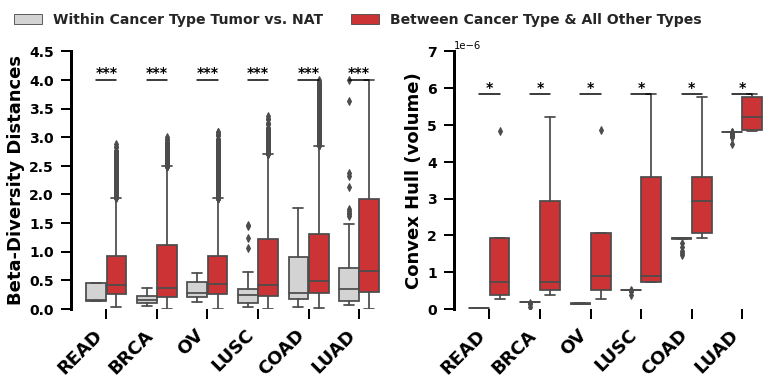

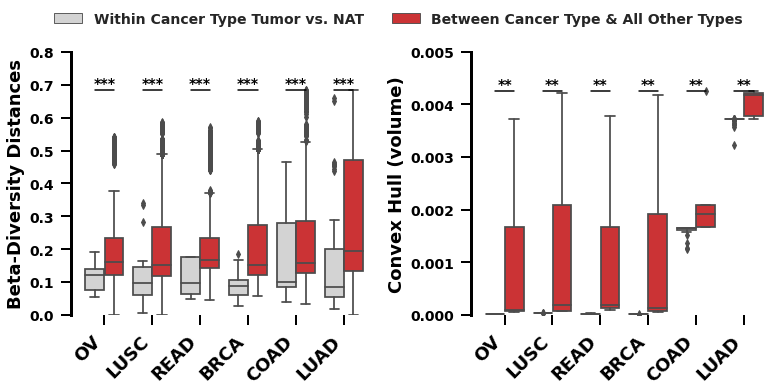

In [364]:
from scipy import stats


label_map = {'BRCA':'Breast Invasive Carcinoma', 'COAD':'Colon Adenocarcinoma',
             'LUAD':'Lung Adenocarcinoma',
             'LUSC':'Lung Squamous Cell Carcinoma',
             'OV':'Ovarian Serous Cystadenocarcinoma',
             'READ':'Rectum Adenocarcinoma'}
stats_all = {}

pal_ = {'Within Cancer Type Tumor vs. NAT':'lightgrey','Between Cancer Type & All Other Types':'#e41a1c'}
hue_ord_ = ['Within Cancer Type Tumor vs. NAT', 'Between Cancer Type & All Other Types']
label_map = {v:k for k, v in label_map.items()}

for metric_ in ['Aitchison', 'Bray-Curtis']:

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5), sharex=True)

    # subset for plot
    between_dist_results_df_plot = between_dist_results_df[between_dist_results_df.metric == metric_].copy()
    convex_hull_results_df_plot = convex_hull_results_df[convex_hull_results_df.metric == metric_].copy()

    between_dist_results_df_plot['disease-type'] = [label_map[x] for x in between_dist_results_df_plot['disease-type']]
    convex_hull_results_df_plot['disease-type'] = [label_map[x] for x in convex_hull_results_df_plot['disease-type']]

    order_ = between_dist_results_df_plot[between_dist_results_df_plot.compare == 'Between Cancer Type & All Other Types'].groupby('disease-type').mean().sort_values('distance').index

    sns.boxplot(x='disease-type', y='distance', hue='compare',
                data=between_dist_results_df_plot, order=order_,
                ax=ax1, showfliers=True, hue_order=hue_ord_, palette=pal_)
    sns.boxplot(x='disease-type', y='volume', hue='compare',
                data=convex_hull_results_df_plot, order=order_,
                ax=ax2, showfliers=True, hue_order=hue_ord_, palette=pal_)

    ax1.set_ylabel('Beta-Diversity Distances',
                  fontsize=18,
                  family = 'arial',
                  weight='bold',
                  color='black')
    ax2.set_ylabel('Convex Hull (volume)',
                  fontsize=18,
                  family = 'arial',
                  weight='bold',
                  color='black')
    for ax in [ax1, ax2]:
        ax.grid(False)
        ax.set_facecolor('white')
        ax.set_axisbelow(True)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        for sp_i in ax.spines.values():
            sp_i.set_linewidth(3)
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('black')
        ax.tick_params(axis='y', colors='black', width=2, length=10)
        ax.tick_params(axis='x', colors='black', width=2, length=10)

        for tick in ax.get_xticklabels():
            tick.set_fontproperties('arial')
            tick.set_ha('right')
            tick.set_rotation(45)
            tick.set_weight("bold")
            tick.set_color("black")
            tick.set_fontsize(18)
        for tick in ax.get_yticklabels():
            tick.set_fontproperties('arial')
            tick.set_weight("bold")
            tick.set_color("black")
            tick.set_fontsize(14)
        ax.set_xlabel('',
                      fontsize=14,
                      family = 'arial',
                      weight='normal',
                      color='black')
        ax.legend_.remove()

    for ax, df_stat, yval, h in zip([ax1, ax2],
                           [between_dist_results_df_plot,
                            convex_hull_results_df_plot],
                           ['distance', 'volume'], [0, 0]):

        for xi, lbl_ in enumerate(order_):


            x_ = df_stat[df_stat['compare'] == hue_ord_[0]][yval].values
            y_ = df_stat[df_stat['compare'] == hue_ord_[1]][yval].values
            stat_ = stats.mannwhitneyu(x_, y_)
            stats_all[(metric_, yval, lbl_)] = stat_
            p_ = stat_.pvalue

            # n.s.
            if p_ >= 0.05:
                p_ = ''
            #*P < 0.05;
            elif p_ < 0.05 and p_ > 0.01:
                p_ = '*'
            #**P < 0.001;
            elif p_ < 0.01 and p_ > 0.001:
                p_ = '**'
            #***P < 0.0001
            elif p_ < 0.001:
                p_ = '***'
            y, col = np.max(y_), 'k'
            x1, x2 = xi - .2, xi + .2
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
            ax.text((x1+x2)*.5, y+h, p_, ha='center', va='bottom',
                    color=col, weight='bold', fontsize=14)

    if metric_ == 'Bray-Curtis':
        ax1.set_ylim(0, 0.8)
        ax2.set_ylim(0, 0.005)
    elif metric_ == 'Aitchison':
        ax1.set_ylim(0, 4.5)
        ax2.set_ylim(0, 7e-6)
    else:
        todo=0

    plt.tight_layout()
    
    handles, labels = ax1.get_legend_handles_labels()
    legend = ax.legend(handles[:], labels[:], loc=2, 
                             bbox_to_anchor=(-1.4, 1.2),
                             prop={'size':14, 'weight':'bold'},
                             fancybox=False, framealpha=.0,
                             ncol=2, markerscale=.5)
    
    plt.savefig('../results/figures/beta-div/%s-between-sample-type-subset.pdf' % (metric_), 
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
    plt.savefig('../results/figures/beta-div/%s-between-sample-type-subset.svg' % (metric_), 
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
    plt.show()



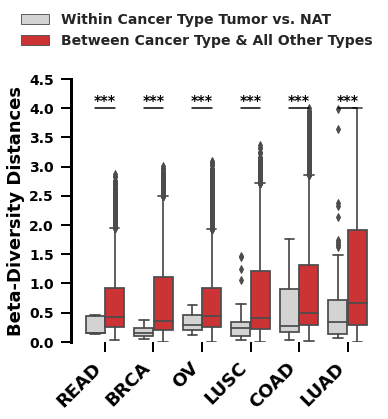

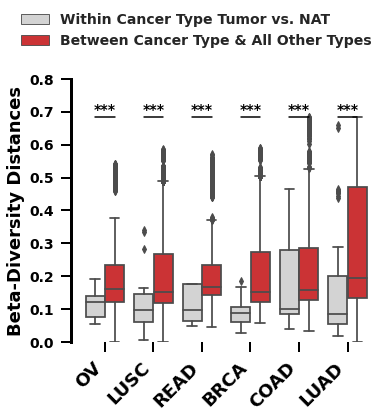

In [368]:
from scipy import stats


label_map = {'BRCA':'Breast Invasive Carcinoma', 'COAD':'Colon Adenocarcinoma',
             'LUAD':'Lung Adenocarcinoma',
             'LUSC':'Lung Squamous Cell Carcinoma',
             'OV':'Ovarian Serous Cystadenocarcinoma',
             'READ':'Rectum Adenocarcinoma'}
stats_all = {}

pal_ = {'Within Cancer Type Tumor vs. NAT':'lightgrey','Between Cancer Type & All Other Types':'#e41a1c'}
hue_ord_ = ['Within Cancer Type Tumor vs. NAT', 'Between Cancer Type & All Other Types']
label_map = {v:k for k, v in label_map.items()}

for metric_ in ['Aitchison', 'Bray-Curtis']:

    fig, ax1 = plt.subplots(1, 1, figsize=(5.5, 5), sharex=True)

    # subset for plot
    between_dist_results_df_plot = between_dist_results_df[between_dist_results_df.metric == metric_].copy()
    convex_hull_results_df_plot = convex_hull_results_df[convex_hull_results_df.metric == metric_].copy()

    between_dist_results_df_plot['disease-type'] = [label_map[x] for x in between_dist_results_df_plot['disease-type']]
    convex_hull_results_df_plot['disease-type'] = [label_map[x] for x in convex_hull_results_df_plot['disease-type']]

    order_ = between_dist_results_df_plot[between_dist_results_df_plot.compare == 'Between Cancer Type & All Other Types'].groupby('disease-type').mean().sort_values('distance').index

    sns.boxplot(x='disease-type', y='distance', hue='compare',
                data=between_dist_results_df_plot, order=order_,
                ax=ax1, showfliers=True, hue_order=hue_ord_, palette=pal_)

    ax1.set_ylabel('Beta-Diversity Distances',
                  fontsize=18,
                  family = 'arial',
                  weight='bold',
                  color='black')

    for ax in [ax1]:
        ax.grid(False)
        ax.set_facecolor('white')
        ax.set_axisbelow(True)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        for sp_i in ax.spines.values():
            sp_i.set_linewidth(3)
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('black')
        ax.tick_params(axis='y', colors='black', width=2, length=10)
        ax.tick_params(axis='x', colors='black', width=2, length=10)

        for tick in ax.get_xticklabels():
            tick.set_fontproperties('arial')
            tick.set_ha('right')
            tick.set_rotation(45)
            tick.set_weight("bold")
            tick.set_color("black")
            tick.set_fontsize(18)
        for tick in ax.get_yticklabels():
            tick.set_fontproperties('arial')
            tick.set_weight("bold")
            tick.set_color("black")
            tick.set_fontsize(14)
        ax.set_xlabel('',
                      fontsize=14,
                      family = 'arial',
                      weight='normal',
                      color='black')
        ax.legend_.remove()

    for ax, df_stat, yval, h in zip([ax1],
                           [between_dist_results_df_plot,
                            convex_hull_results_df_plot],
                           ['distance', 'volume'], [0, 0]):

        for xi, lbl_ in enumerate(order_):


            x_ = df_stat[df_stat['compare'] == hue_ord_[0]][yval].values
            y_ = df_stat[df_stat['compare'] == hue_ord_[1]][yval].values
            stat_ = stats.mannwhitneyu(x_, y_)
            stats_all[(metric_, yval, lbl_)] = stat_
            p_ = stat_.pvalue

            # n.s.
            if p_ >= 0.05:
                p_ = ''
            #*P < 0.05;
            elif p_ < 0.05 and p_ > 0.01:
                p_ = '*'
            #**P < 0.001;
            elif p_ < 0.01 and p_ > 0.001:
                p_ = '**'
            #***P < 0.0001
            elif p_ < 0.001:
                p_ = '***'
            y, col = np.max(y_), 'k'
            x1, x2 = xi - .2, xi + .2
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
            ax.text((x1+x2)*.5, y+h, p_, ha='center', va='bottom',
                    color=col, weight='bold', fontsize=14)

    if metric_ == 'Bray-Curtis':
        ax1.set_ylim(0, 0.8)
    else:
        ax1.set_ylim(0, 4.5)
        todo=0

    plt.tight_layout()
    
    handles, labels = ax1.get_legend_handles_labels()
    legend = ax.legend(handles[:], labels[:], loc=2, 
                             bbox_to_anchor=(-0.2, 1.3),
                             prop={'size':14, 'weight':'bold'},
                             fancybox=False, framealpha=.0,
                             ncol=1, markerscale=.5)
    
    plt.savefig('../results/figures/beta-div/%s-between-sample-type-subset-beta-only.pdf' % (metric_), 
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
    plt.savefig('../results/figures/beta-div/%s-between-sample-type-subset-beta-only.svg' % (metric_), 
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
    plt.show()


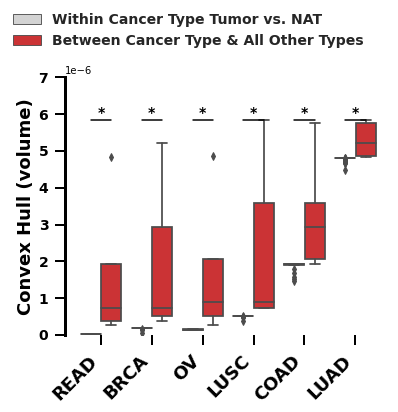

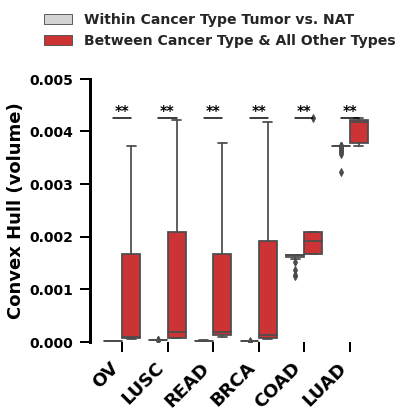

In [369]:
from scipy import stats


label_map = {'BRCA':'Breast Invasive Carcinoma', 'COAD':'Colon Adenocarcinoma',
             'LUAD':'Lung Adenocarcinoma',
             'LUSC':'Lung Squamous Cell Carcinoma',
             'OV':'Ovarian Serous Cystadenocarcinoma',
             'READ':'Rectum Adenocarcinoma'}
stats_all = {}

pal_ = {'Within Cancer Type Tumor vs. NAT':'lightgrey','Between Cancer Type & All Other Types':'#e41a1c'}
hue_ord_ = ['Within Cancer Type Tumor vs. NAT', 'Between Cancer Type & All Other Types']
label_map = {v:k for k, v in label_map.items()}

for metric_ in ['Aitchison', 'Bray-Curtis']:

    fig, ax2 = plt.subplots(1, 1, figsize=(5.5, 5), sharex=True)

    # subset for plot
    between_dist_results_df_plot = between_dist_results_df[between_dist_results_df.metric == metric_].copy()
    convex_hull_results_df_plot = convex_hull_results_df[convex_hull_results_df.metric == metric_].copy()

    between_dist_results_df_plot['disease-type'] = [label_map[x] for x in between_dist_results_df_plot['disease-type']]
    convex_hull_results_df_plot['disease-type'] = [label_map[x] for x in convex_hull_results_df_plot['disease-type']]

    order_ = between_dist_results_df_plot[between_dist_results_df_plot.compare == 'Between Cancer Type & All Other Types'].groupby('disease-type').mean().sort_values('distance').index

    sns.boxplot(x='disease-type', y='volume', hue='compare',
                data=convex_hull_results_df_plot, order=order_,
                ax=ax2, showfliers=True, hue_order=hue_ord_, palette=pal_)

    ax2.set_ylabel('Convex Hull (volume)',
                  fontsize=18,
                  family = 'arial',
                  weight='bold',
                  color='black')
    for ax in [ax2]:
        ax.grid(False)
        ax.set_facecolor('white')
        ax.set_axisbelow(True)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        for sp_i in ax.spines.values():
            sp_i.set_linewidth(3)
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('black')
        ax.tick_params(axis='y', colors='black', width=2, length=10)
        ax.tick_params(axis='x', colors='black', width=2, length=10)

        for tick in ax.get_xticklabels():
            tick.set_fontproperties('arial')
            tick.set_ha('right')
            tick.set_rotation(45)
            tick.set_weight("bold")
            tick.set_color("black")
            tick.set_fontsize(18)
        for tick in ax.get_yticklabels():
            tick.set_fontproperties('arial')
            tick.set_weight("bold")
            tick.set_color("black")
            tick.set_fontsize(14)
        ax.set_xlabel('',
                      fontsize=14,
                      family = 'arial',
                      weight='normal',
                      color='black')
        ax.legend_.remove()

    for ax, df_stat, yval, h in zip([ax2],
                           [convex_hull_results_df_plot],
                           ['volume'], [0, 0]):

        for xi, lbl_ in enumerate(order_):


            x_ = df_stat[df_stat['compare'] == hue_ord_[0]][yval].values
            y_ = df_stat[df_stat['compare'] == hue_ord_[1]][yval].values
            stat_ = stats.mannwhitneyu(x_, y_)
            stats_all[(metric_, yval, lbl_)] = stat_
            p_ = stat_.pvalue

            # n.s.
            if p_ >= 0.05:
                p_ = ''
            #*P < 0.05;
            elif p_ < 0.05 and p_ > 0.01:
                p_ = '*'
            #**P < 0.001;
            elif p_ < 0.01 and p_ > 0.001:
                p_ = '**'
            #***P < 0.0001
            elif p_ < 0.001:
                p_ = '***'
            y, col = np.max(y_), 'k'
            x1, x2 = xi - .2, xi + .2
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
            ax.text((x1+x2)*.5, y+h, p_, ha='center', va='bottom',
                    color=col, weight='bold', fontsize=14)

    if metric_ == 'Bray-Curtis':
        ax2.set_ylim(0, 0.005)
    else:
        ax2.set_ylim(0, 7e-6)
        todo=0

    plt.tight_layout()
    
    handles, labels = ax2.get_legend_handles_labels()
    legend = ax.legend(handles[:], labels[:], loc=2, 
                             bbox_to_anchor=(-0.2, 1.3),
                             prop={'size':14, 'weight':'bold'},
                             fancybox=False, framealpha=.0,
                             ncol=1, markerscale=.5)
    
    plt.savefig('../results/figures/beta-div/%s-between-sample-type-subset-hull-only.pdf' % (metric_), 
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
    plt.savefig('../results/figures/beta-div/%s-between-sample-type-subset-hull-only.svg' % (metric_), 
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
    plt.show()
